<center><h1><span style="color: #f2cf4a; font-size: 1.2em; line-height:40px">DS-GA 1003 Machine Learning&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br/>Yelp's Fake Review Detection</span></h1></center>

<center><h3>Members: Kuan-Lin Liu, Hao-Ning Wu</h3></center>
<a id='Top'></a>

## Table of Contents

* [Reading in Data](#Reading-in-Data)
* [Raw Data Exploration](#Raw-Data-Exploration)
* [Feature Pre-processing](#Feature-Pre-processing)
* [Pre-processed Feature Visualization](#Pre-processed-Feature-Visualization)
* [Model Tuning](#Model-Tuning)
* [Training with Full Dataset](#Training-with-Full-Dataset)

<a id='Reading-in-Data'></a>
## 1. Reading in Data

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import joblib
import seaborn as sns

%matplotlib inline

In [2]:
data_path = "data/"

In [3]:
train = pd.read_csv(data_path+"train.csv")
val = pd.read_csv(data_path+"dev.csv")
test = pd.read_csv(data_path+"test_no_label.csv")
train['set']='train'
val['set']='val'
test['set']='test'
train.head()

,ex_id,user_id,prod_id,rating,label,date,review,set
0,0,923,0,3.0,1,2014-12-08,The food at snack is a selection of popular Gr...,train
1,1,924,0,3.0,1,2013-05-16,This little place in Soho is wonderful. I had ...,train
2,2,925,0,4.0,1,2013-07-01,ordered lunch for 15 from Snack last Friday. ...,train
3,3,926,0,4.0,1,2011-07-28,This is a beautiful quaint little restaurant o...,train
4,4,927,0,4.0,1,2010-11-01,Snack is great place for a casual sit down lu...,train


In [4]:
val.head()

,ex_id,user_id,prod_id,rating,label,date,review,set
0,11,934,0,5.0,1,2014-01-20,"all around good place, cozy, I came in and did...",val
1,17,940,0,4.0,0,2014-09-16,"For lunch, my friend and I had: -Lamb sandwich...",val
2,20,943,0,5.0,0,2014-05-24,Some good Big Greek cooking!! Came to City on ...,val
3,30,953,0,4.0,0,2013-10-17,So... as you may notice from some of my other ...,val
4,43,966,0,3.0,0,2012-12-19,"I don't understand the whole ""You can't order ...",val


Merge train and val datasets for exploration.

In [17]:
data = pd.concat([train, val, test])
data_raw = pd.concat([train, val])

In [18]:
print("Full data dimension: {}".format(data_raw.shape))
print("Training data dimension: {}".format(train.shape))
print("Validation data dimension: {}".format(val.shape))
print("---")
print(data_raw.dtypes)

Full data dimension: (286792, 8)
Training data dimension: (250874, 8)
Validation data dimension: (35918, 8)
---
ex_id        int64
user_id      int64
prod_id      int64
rating     float64
label        int64
date        object
review      object
set         object
dtype: object


The training data contains <font color='blue'>250,874</font> rows and the testing data contains <font color='blue'>35,918</font> rows. They both have <font color='blue'>7</font> columns.

[Back to Top](#Top)

<a id='Raw-Data-Exploration'></a>
## 2. Raw Data Exploration
### 2.1. What is ex_id?
From the length of the unique data in ex_id, I guess it represents an index of the row.
Besides, I guess user_id and prod_id mean the index of users and products (items).

In [19]:
def unique_data_len(data, col_name):
    return data[col_name].unique().__len__()

print("Length of Unique Rows:")
for col in ["ex_id", "user_id", "prod_id", "rating", "label"]:
    print(col + ": {}".format(unique_data_len(data_raw, col)))

Length of Unique Rows:
ex_id: 286792
user_id: 137692
prod_id: 923
rating: 5
label: 2


### 2.2. Rating
The "rating" column has 5 unique classes, 1 to 5.
Most people gave positive ratings, 4 and 5.

In [20]:
rating_count = pd.DataFrame(data_raw["rating"].value_counts())
print(rating_count)

     rating
5.0  112518
4.0  108145
3.0   38026
2.0   16603
1.0   11500


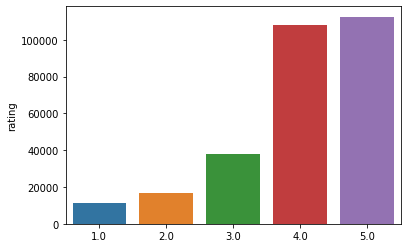

In [21]:
sns.barplot(x=rating_count.index, y=rating_count["rating"])

### 2.3. Review
The maximal length of reviews is 29012. The minimum is 1.

In [22]:
print(data_raw["review"].apply(lambda row: len(row)).max())
print(data_raw["review"].apply(lambda row: len(row)).min())

29012
1


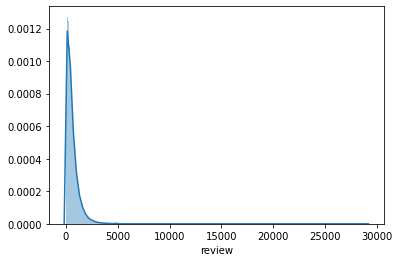

In [23]:
sns.distplot(
    data_raw["review"].apply(lambda row: len(row)),
    bins = 500
)

### 2.4. Label

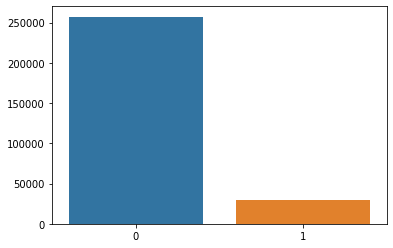

In [24]:
sns.barplot(x=data_raw["label"].value_counts().index, y=data_raw["label"].value_counts().values)

### 2.5. Label Vs. Rating

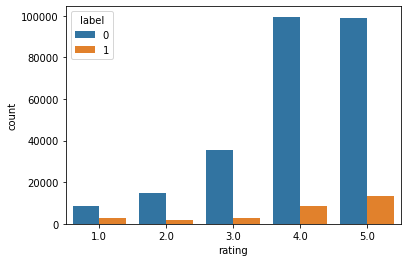

In [26]:
sns.countplot(x=data_raw["rating"], hue=data_raw["label"])

[Back to Top](#Top)
<a id='Feature-Pre-processing'></a>
## 3. Feature Pre-processing

In [27]:
# 2014-12-08 (object) => 20141208 (int)
data["date_int"] = pd.to_datetime(data["date"]).dt.strftime("%Y%m%d").apply(pd.to_numeric)
# How many seconds have passed since 1970-01-01
data["date_offset"] = (pd.to_datetime(data["date"]) - pd.to_datetime('1970-01-01')).dt.total_seconds().astype(int)

In [28]:
# Check holidays and weekends
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()
holidays = cal.holidays(start=data['date'].min(), end=data['date'].max())
data['holiday'] = pd.DatetimeIndex(data['date']).isin(holidays)
data['weekend'] = pd.to_datetime(data["date"]).dt.dayofweek
data['weekend'] = data['weekend'] >= 5

In [29]:
# a spammer is a user with more than 0 fake reviews
df_spammer = data[['user_id','label']].groupby("user_id").sum().apply(lambda x: x>0).reset_index()
df_spammer.rename(columns = {'label':'spammer'}, inplace = True)
data = data.merge(df_spammer)

In [30]:
# count how many reviews per user per day
df_dailyreview = data[['user_id','date']].groupby(['user_id','date']).size().to_frame('size').reset_index()
# max reviews per day
df_dailyreview['max_daily_review'] = df_dailyreview[['user_id', 'size']].groupby(['user_id']).transform('max')
# avg reviews per day
df_dailyreview['avg_daily_review'] = df_dailyreview[['user_id', 'size']].groupby(['user_id']).transform('mean')
df_newdailyreview = df_dailyreview[['user_id', 'max_daily_review', 'avg_daily_review']].drop_duplicates(['user_id'])
data = data.merge(df_newdailyreview)

In [31]:
# super slow !@#$%^&*()$#@!@#@
# % positive reviews per user
data['pos_review_rate'] = data[['user_id','rating']].groupby(['user_id']).transform(lambda x: len(x[x >= 4]) / len(x))
# % negative reviews per user
data['neg_review_rate'] = data[['user_id','rating']].groupby(['user_id']).transform(lambda x: len(x[x <= 1]) / len(x))

In [32]:
# number of rating per user
data['num_user_rating'] = data[['user_id','rating']].groupby(['user_id']).transform('count')
# number of rating per product
data['num_prod_rating'] = data[['prod_id','rating']].groupby(['prod_id']).transform('count')
# summation of rating per product
data['sum_prod_rating'] = data[['prod_id','rating']].groupby(['prod_id']).transform('sum')
# compute absolute deviation from the average product rating for each review
# Formula from "Spotting Opinion Spammers using Behavioral Footprints"
data['review_dev'] = data[['rating','num_prod_rating', 'sum_prod_rating']].apply(
    lambda x: np.abs(x.rating - (x.sum_prod_rating - x.rating) / (x.num_prod_rating - 1)) / 4, axis=1)
# compute mean deviation per user
data['avg_user_dev'] = data[['user_id','review_dev']].groupby(['user_id']).transform('mean')

In [33]:
# First review date for each product
data['first_review_prod'] = data[['prod_id','date_offset']].groupby(['prod_id']).transform('min')
# Reviews written with the first 7 months
data['early_time_frame'] = data[['first_review_prod','date_offset']].apply(
    lambda x: np.maximum(0, 1 - (x.date_offset - x.first_review_prod) // 86400 / (7 * 30)), axis=1)

In [34]:
# First review date for each user
data['first_review_user'] = data[['user_id','date_offset']].groupby(['user_id']).transform('min')
data['last_review_user'] = data[['user_id','date_offset']].groupby(['user_id']).transform('max')
# All reviews written in 28 days
data['burstiness'] = data[['first_review_user','last_review_user']].apply(
    lambda x: np.maximum(0, 1 - (x.last_review_user - x.first_review_user) // 86400 / 28), axis=1)

In [35]:
# Review length related features
data["review_len"] = data["review"].apply(lambda row: len(row))
data['avg_user_len'] = data[['user_id','review_len']].groupby(['user_id']).transform('mean')
data['var_user_len'] = data[['user_id','review_len']].groupby(['user_id']).transform('var')

In [36]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
import warnings
from sklearn.exceptions import DataConversionWarning
from scipy.sparse import csr_matrix
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

def content_similarity(x, dist_name='cosine'):
    x_2d = np.array(x.values.tolist())
    dist_func = cosine_similarity
    if len(x_2d) <= 1:
        return 0
    # remove the self-similarities on the diagonal
    if dist_name == 'cosine':
        return (np.sum(cosine_similarity(x_2d, x_2d)) - len(x_2d)) / (len(x_2d) ** 2 - len(x_2d))
    else:
        return (np.sum(pairwise_distances(x_2d, x_2d, metric=dist_name)) - len(x_2d)) / (len(x_2d) ** 2 - len(x_2d))

In [37]:
train_glove = np.load('train_embedding_glove_50d_282.npy')
test_glove = np.load('test_embedding_glove_50d_282.npy')
exid = pd.concat([train, val, test])[['ex_id']]
exid['glove_50d'] = list(train_glove)+list(test_glove)
train_bow = np.load('train_BOW_500_1gram.npy', allow_pickle=True).item()
test_bow = np.load('test_BOW_500_1gram.npy', allow_pickle=True).item()
train_bow = np.asarray(csr_matrix.todense(train_bow))
test_bow = np.asarray(csr_matrix.todense(test_bow))                                  
exid['bow_500d'] = list(train_bow)+list(test_bow)
data = data.merge(exid)

data['cosine_similarity'] = data[['user_id', 'glove_50d']].groupby(['user_id']).transform(lambda x: content_similarity(x))
data['jaccard_similarity'] = data[['user_id', 'bow_500d']].groupby(['user_id']).transform(lambda x: content_similarity(x, 'jaccard'))

In [38]:
data.to_pickle('data.pickle')
#data = pd.read_pickle('data.pickle')

In [44]:
data_nan = data.isna().sum()
data_nan[data_nan != 0]

label            72165
var_user_len    105986
dtype: int64

[Back to Top](#Top)
<a id='Pre-processed-Feature-Visualization'></a>
## 4. Pre-processed Feature Visualization
### 4.1 Reviews Length Vs. Label

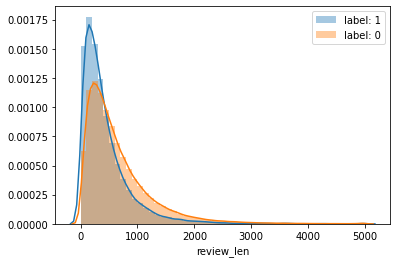

In [40]:
# Ignore review_len > 5000
sns.distplot(data.loc[(data["review_len"]<5000) & (data["label"]==1),"review_len"], label="label: 1")
sns.distplot(data.loc[(data["review_len"]<5000) & (data["label"]==0),"review_len"], label="label: 0")
plt.legend()

### 4.2 Mean/Var of Reviews Length

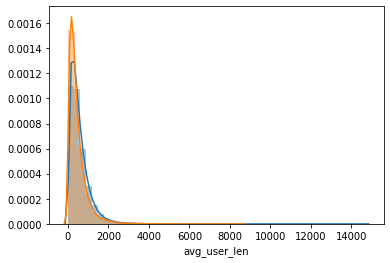

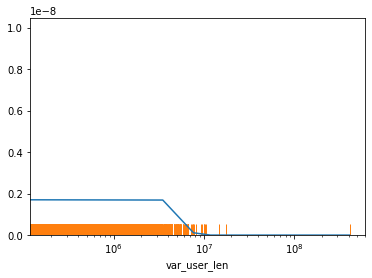

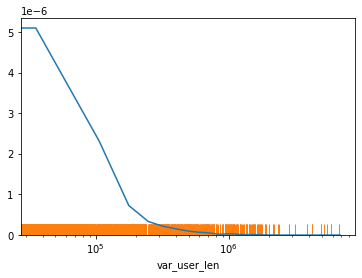

In [41]:
for label in [0, 1]:
    sns.distplot(
        data[data['label'] == label].drop_duplicates(["user_id"])['avg_user_len'],
        bins = 50
    )

for label in [0, 1]:   
    plt.figure()
    grid = sns.distplot(data[data['label'] == label].drop_duplicates(
        ["user_id"])['var_user_len'].dropna(), hist=False, rug=True, rug_kws={"color": "C1"})
    grid.set(xscale="log")

### 4.3 Other Per-user Features

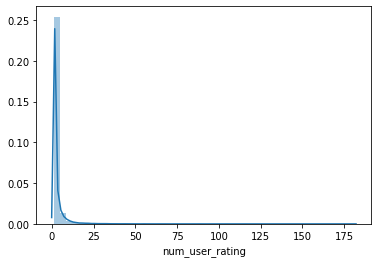

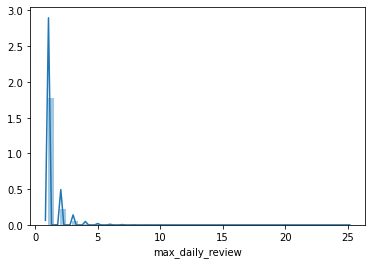

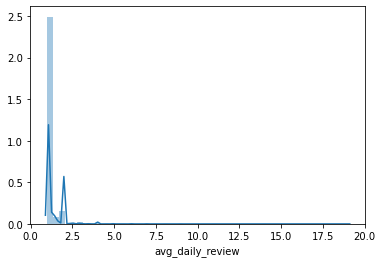

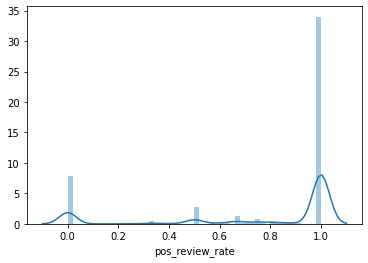

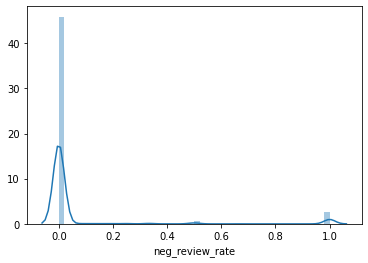

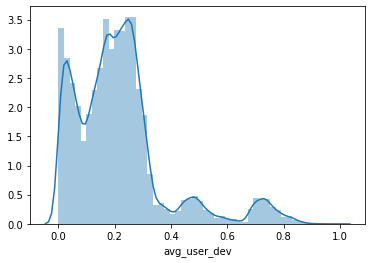

In [45]:
per_user_features = ['num_user_rating', 'max_daily_review', 'avg_daily_review', 
                     'pos_review_rate', 'neg_review_rate', 'avg_user_dev']

for f in per_user_features:
    plt.figure()
    sns.distplot(
        data.drop_duplicates(["user_id"])[f],
        bins = 50
    )

[Back to Top](#Top)
<a id='Model-Tuning'></a>
## 5. Model Tuning

In [51]:
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV, train_test_split
#from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, QuantileTransformer
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

In [52]:
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE 
from imblearn.ensemble import BalancedBaggingClassifier 
import xgboost as xgb
from xgboost import XGBClassifier

In [83]:
def evaluate(model, X_test, y_test):
    y_scores = model.predict_proba(X_test)[:,1]
    for m in [average_precision_score, roc_auc_score]:
        print("{}: {}".format(m.__name__, m(y_test, y_scores)))
    y_scores = model.predict(X_test)
    for m in [precision_score, recall_score, accuracy_score]:
        print("{}: {}".format(m.__name__, m(y_test, y_scores)))

In [158]:
def get_model(model_name, resampler=None, param_grid=None, new_arg=None):
    model = None
    
    # models with default parameters
    if model_name == 'LR':
        model = LogisticRegression(C=1, class_weight='balanced')
    elif model_name == 'SVC':
        model = SVC(C=10, class_weight='balanced', gamma=10**-0.5)
    elif model_name == 'NB':
        model = GaussianNB()
    elif model_name == 'XGB':
        model = XGBClassifier(learning_rate=0.1, max_depth=6, n_estimators=1000, 
                        scale_pos_weight=POS_WEIGHT, max_delta_step=10, eval_metric='auc')
        
    if new_arg:
        model.set_params(**new_arg)
    
    # Should not re-weight classes if using an over/under-sampler 
    if resampler:
        if model_name in ['LR', 'SVC']:
            model.set_params(class_weight = None)
        elif model_name in ['XGB']:
            model.set_params(scale_pos_weight = None)
        model = make_pipeline(
            resampler,
            model
        ) 
        
    if param_grid:
        scoring = {'AUC': 'roc_auc', 'AP': 'average_precision'}
        if resampler:
            model_infix = model.steps[1][0] + '__'
            old_keys = list(param_grid.keys())
            for k in old_keys:
                param_grid[model_infix + k] = param_grid.pop(k, None)
        model = GridSearchCV(model,
             param_grid=param_grid,
             cv=3,
             scoring=scoring,
             refit='AUC')
        
    return model

In [150]:
skewed_features = ['review_len', 'num_user_rating', 'max_daily_review', 'avg_daily_review', 'avg_user_len']
std_features = skewed_features + ['rating', 'var_user_len']
used_features = std_features + ['pos_review_rate', 'neg_review_rate', 'review_dev', 'avg_user_dev', 
                                'holiday', 'weekend', 'cosine_similarity', 'jaccard_similarity']

data_training = data[data['set'] != 'test'][used_features].copy()
data_training.fillna(0, inplace=True)

for f in skewed_features:
    data_training[f] = np.log(data_training[f])

labels = data[data['set'] != 'test'][['label']].values.ravel()

use_bow = True
if use_bow:
    data_training = np.concatenate((data_training, np.array(data[data['set'] != 'test']['bow_500d'].values.tolist())), 1)
    std_features = np.arange(7) # data_training became numpy array
    
X_train, X_val, y_train, y_val = train_test_split(data_training, labels, test_size=0.2, random_state=0)

# columnss to standardize
standardization = make_column_transformer(
    (StandardScaler(), std_features),
    remainder='passthrough'
)

standardization.fit(X_train)
X_train = standardization.transform(X_train)
X_val = standardization.transform(X_val)

POS_WEIGHT = len(y_train[y_train==0])/len(y_train[y_train==1])

In [ ]:
model = get_model('XGB', param_grid = {'learning_rate': [0.1], 'max_depth': [7, 8, 9], 
                        'max_delta_step': [0], 'n_estimators': [1500], 'colsample_bytree': [0.7, 0.8, 0.9],
                        'subsample': [0.8, 1]})
model.fit(X_train, y_train)
evaluate(model, X_val, y_val)
model.best_params_

### Example of Usage
Training with default parameters 

In [134]:
model = get_model('XGB')
model.fit(X_train, y_train)
evaluate(model, X_val, y_val)

average_precision_score: 0.4227471461125748
roc_auc_score: 0.8678166367767061
precision_score: 0.2657866015279871
recall_score: 0.8776385790286597
accuracy_score: 0.741278613643892


Training with new parameters

In [120]:
model = get_model('XGB', new_arg={'max_depth': 4})
model.fit(X_train, y_train)
evaluate(model, X_val, y_val)

average_precision_score: 0.37502052451565077
roc_auc_score: 0.848973662861464
precision_score: 0.24044152184124
recall_score: 0.8784966535095247
accuracy_score: 0.7057305741034536


Training with resampler

In [122]:
model = get_model('XGB', resampler=RandomOverSampler())
model.fit(X_train, y_train)
evaluate(model, X_val, y_val)

average_precision_score: 0.4213968505738366
roc_auc_score: 0.8671136624386545
precision_score: 0.26540656578878474
recall_score: 0.8699159087008752
accuracy_score: 0.7421851845394795


Performing grid search with resampler

In [149]:
model = get_model('LR', resampler=RandomUnderSampler(), param_grid = {'C':10.0 ** np.array([0, -0.5, -1]),})
model.fit(X_train, y_train)
evaluate(model, X_val, y_val)
model.best_params_

average_precision_score: 0.26756529871609974
roc_auc_score: 0.7966161983041763
precision_score: 0.2135154893539249
recall_score: 0.8019564098163721
accuracy_score: 0.6797886992451054


{'logisticregression__C': 1.0}

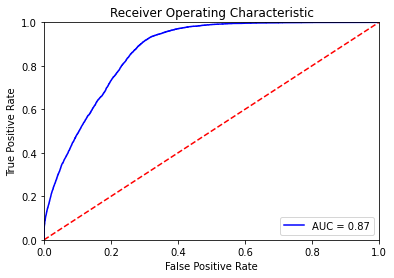

In [135]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(y_val, model.predict_proba(X_val)[:,1])
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

[Back to Top](#Top)
<a id='Training-with-Full-Dataset'></a>
## 6. Training with Full Dataset

In [128]:
X_train_val = data[data['set'] != 'test'][used_features].copy()
y_train_val = data[data['set'] != 'test']['label'].copy()
X_train_val.fillna(0, inplace=True)
X_test = data[data['set'] == 'test'].sort_values('ex_id')[used_features].copy()
X_test.fillna(0, inplace=True)

for f in skewed_features:
    X_train_val[f] = np.log(X_train_val[f])
    X_test[f] = np.log(X_test[f])
    
standardization = make_column_transformer(
    (StandardScaler(), std_features),
    remainder='passthrough'
)

standardization.fit(X_train_val)
X_train_val = standardization.transform(X_train_val)
X_test = standardization.transform(X_test)


xgb_pipline = get_model('XGB', resampler=RandomOverSampler(), new_arg={'n_estimators': 1500})
xgb_pipline.fit(X_train_val, y_train_val)

Pipeline(memory=None,
         steps=[('randomoversampler',
                 RandomOverSampler(random_state=None,
                                   sampling_strategy='auto')),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='auc', gamma=0,
                               gpu_id=-1, importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=10, max_depth=6,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=1500,
                               n_jobs=0, num_parallel_tree=1,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
         

In [129]:
evaluate(xgb_pipline, X_train_val, y_train_val)
y_scores = xgb_pipline.predict_proba(X_test)[:,1]
#np.savetxt("predictions.csv", y_scores, delimiter=",")

average_precision_score: 0.6320931895836759
roc_auc_score: 0.9335119955672436
precision_score: 0.30978671749385067
recall_score: 0.9873078358842095
accuracy_score: 0.7726784568607213


[Back to Top](#Top)